In [ ]:
import pandas as pd
import numpy as np
import talib as ta
import joblib
from backtesting import Backtest, Strategy

/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [ ]:
class WeeklyLongMondayGreen(Strategy):
    ema_period = 200
    kelly_factor = 0.5
    alpha = 0.01
    atr_period = 14
    atr_multiplier = 2
    sell_side = True
    trade_date = [0, 1, 2]

    def init(self):
        self.monday_open = None
        self.monday_close = None
        self.long_week = False
        self.entered_this_week = False
        self.current_week = None
        self.entry_index = None
        self.max_price_since_entry = None
        self.trailing_atr_value = None

        self.daily_returns = []
        self.long_week_array = np.zeros(len(self.data))
        self.kelly_array = np.zeros(len(self.data))

        self.long_week_plot = self.I(lambda: self.long_week_array, name='LongWeek', plot=False)
        self.kelly_plot = self.I(lambda: self.kelly_array, name='KellyFraction')

        self.ema = self.I(ta.EMA, self.data.Close, timeperiod=self.ema_period)
        self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close, timeperiod=self.atr_period, plot=False)
        self.rsi = self.I(ta.RSI, self.data.Close, timeperiod=self.atr_period, plot=True)

        self.trailing_stop_array = np.full(len(self.data), np.nan)
        self.trailing_stop_plot = self.I(lambda: self.trailing_stop_array, name='TrailingStop', plot=False)

    def kelly_fraction(self):
        if len(self.daily_returns) < 30:
            return self.kelly_factor
        sigma = np.std(self.daily_returns[-30:]) * np.sqrt(360)
        if sigma == 0:
            return self.kelly_factor
        target_vol = np.std(self.daily_returns[-360:]) * np.sqrt(360)
        size = target_vol / sigma * self.kelly_factor
        return max(min(size, 1), 0)
    
    def next(self):
        i = len(self.data) - 1
        date = self.data.index[i]
        dayofweek = date.dayofweek
        week_number = date.isocalendar()[1]

        # Update daily returns
        if i > 0:
            prev_close = self.data.Close[i - 1]
            today_close = self.data.Close[i]
            daily_ret = (today_close - prev_close) / prev_close
            self.daily_returns.append(daily_ret)
            if len(self.daily_returns) > 400:
                self.daily_returns.pop(0)

        # Kelly sizing
        kelly_f = self.kelly_fraction()
        self.kelly_array[i] = kelly_f

        # Weekly reset
        if self.current_week != week_number:
            self.current_week = week_number
            self.monday_open = None
            self.monday_close = None
            self.tuesday_close = None
            self.long_week = False
            self.short_week = False
            self.entered_this_week = False

        # Monday open and close tracking
        if dayofweek == 0 and dayofweek in self.trade_date:
            if self.monday_open is None:
                self.monday_open = self.data.Open[i]
            self.monday_close = self.data.Close[i]
        
        if dayofweek == 1:
            self.tuesday_close = self.data.Close[i]

        price = self.data.Close[i]
        ema = self.ema[i]
        atr = self.atr[i] * self.atr_multiplier

        # Bias week logic
        if dayofweek == 0:
            if not self.long_week or self.short_week:
                if self.monday_close and self.monday_open:
                    if price > ema:
                        self.long_week = True
                    else:
                        self.short_week = True 
        
        # Switch sell side
        if self.sell_side:
            self.short_week = self.short_week
        else:
            self.short_week = False
                
        # Entry condition on Monday
        if dayofweek == 0 and not self.entered_this_week:
            if self.long_week and self.monday_close > (self.monday_open * (1 + self.alpha)):
                if kelly_f > 0:
                    self.buy(size=kelly_f)
                    self.entry_index = i
                    self.entered_this_week = True
                    self.max_price_since_entry = price
                    self.trailing_atr_value = atr

            elif self.short_week and self.monday_close < (self.monday_open * (1 - self.alpha)):
                if kelly_f > 0:
                    self.sell(size=kelly_f)
                    self.entry_index = i
                    self.entered_this_week = True
                    self.max_price_since_entry = price
                    self.trailing_atr_value = atr

        # Entry condition on Tuesday
        if dayofweek == 1 and not self.entered_this_week:
            if self.long_week:
                if self.tuesday_close > self.monday_open * (1 + self.alpha):
                    if kelly_f > 0:
                        self.buy(size=kelly_f)
                        self.entry_index = i
                        self.entered_this_week = True
                        self.max_price_since_entry = price
                        self.trailing_atr_value = atr

            elif self.short_week:
                if self.tuesday_close < self.monday_open * (1 - self.alpha):
                    if kelly_f > 0:
                        self.sell(size=kelly_f)
                        self.entry_index = i
                        self.entered_this_week = True
                        self.max_price_since_entry = price
                        self.trailing_atr_value = atr
        
        # Entry condition on Wednesday
        if dayofweek == 2 and not self.entered_this_week:
            if self.long_week:
                if self.tuesday_close > self.monday_open * (1 + self.alpha * 2):
                    if kelly_f > 0:
                        self.buy(size=kelly_f)
                        self.entry_index = i
                        self.entered_this_week = True
                        self.max_price_since_entry = price
                        self.trailing_atr_value = atr

            elif self.short_week:
                if self.tuesday_close < self.monday_open * (1 - self.alpha * 2):
                    if kelly_f > 0:
                        self.sell(size=kelly_f)
                        self.entry_index = i
                        self.entered_this_week = True
                        self.max_price_since_entry = price
                        self.trailing_atr_value = atr

        # Exit logic long
        if self.position.is_long:
            self.max_price_since_entry = max(self.max_price_since_entry, price)
            trailing_stop = self.max_price_since_entry - self.trailing_atr_value
            self.trailing_stop_array[i] = trailing_stop  # Store for plotting

            if price < trailing_stop or price < ema - self.alpha * ema:
                self.position.close()
                self.long_week = False
        else:
            self.trailing_stop_array[i] = np.nan
   
        # Exit logic short
        if self.position.is_short:
            self.max_price_since_entry = min(self.max_price_since_entry, price)
            trailing_stop = self.max_price_since_entry + self.trailing_atr_value
            self.trailing_stop_array[i] = trailing_stop  # Store for plotting

            if price > trailing_stop or price > ema + self.alpha * ema:
                self.position.close()
                self.short_week = False
        else:
            self.trailing_stop_array[i] = np.nan

        # Exit on Sunday
        if dayofweek == 6:
            self.position.close()
            self.long_week = False
            self.short_week = False

        # Plot long-week status
        self.long_week_array[i] = 1 if self.long_week else 0

In [ ]:
# Parameterized version for quick testing or optimization
class WeeklyLongMondayGreen_params(WeeklyLongMondayGreen):
    ema_period = 50
    kelly_factor = 0.4
    alpha = 0.001
    atr_period = 20
    atr_multiplier = 2.5
    sell_side = False
    trade_date = [0, 1, 2]

In [ ]:
data_dict = joblib.load('crypto_data.pkl')

results = {}
returns = {}
close = {}
for asset in data_dict.keys():
    data = data_dict[asset]
    data.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.set_index('Datetime', inplace=True)

    bt = Backtest(data, WeeklyLongMondayGreen_params, cash=1_000_000, commission=0.0005)
    bt.run()
    
    close[asset] = data.Close
    returns[asset] = bt._results['_equity_curve'].Equity
    results[asset] = bt

dd = {}
sharpe = {}
for asset, bt in results.items():
    dd[asset] = bt._results['Avg. Drawdown [%]']
    sharpe[asset] = bt._results['Sharpe Ratio']

<Axes: >

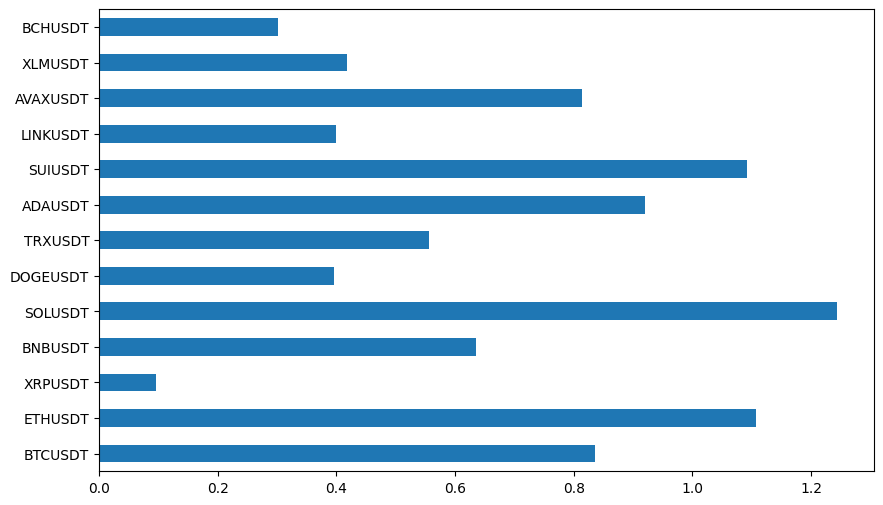

In [ ]:
pd.Series(sharpe).plot(kind='barh', figsize=(10, 6))

<Axes: >

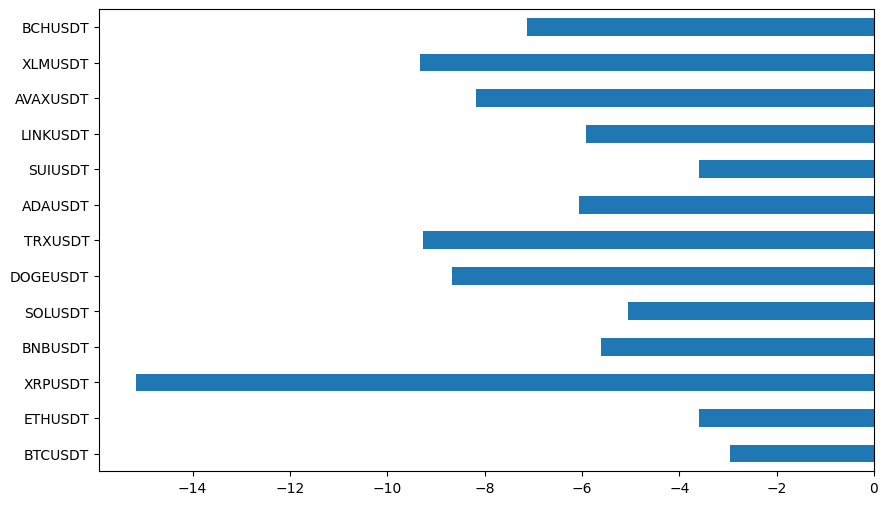

In [ ]:
pd.Series(dd).plot(kind='barh', figsize=(10, 6))

<Axes: >

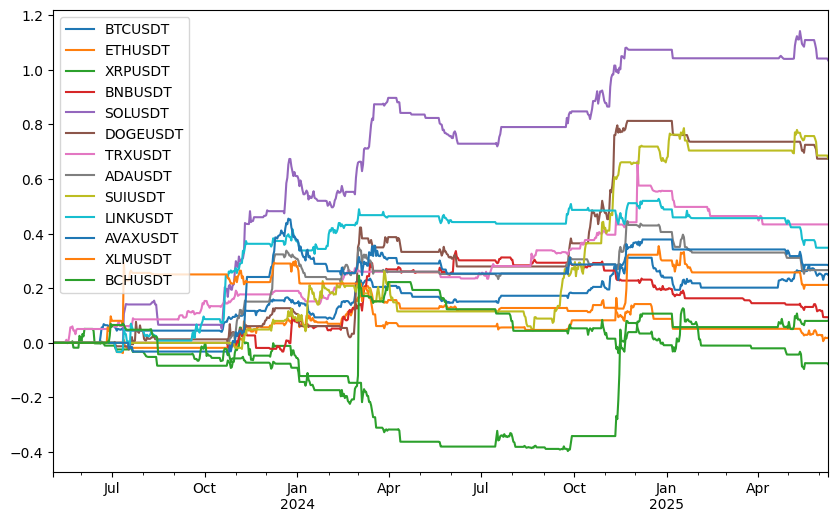

In [ ]:
pd.DataFrame(returns).pct_change().dropna().cumsum().plot(figsize=(10, 6))

In [ ]:
results['ETHUSDT'].plot()

GridPlot(id='p1906', ...)